# Proportional Integral Derivative(PID) Controller
Proportional Integral Derivative (PID) control automatically adjusts a control output based on the difference between a set point (SP) and a measured process variable (PV). The value of the controller output $u(t)$ is transferred as the system input.
$$e(t) = SP-PV$$
$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\int_0^t e(t)dt - K_c \tau_D \frac{d(PV)}{dt}$$
$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\sum_{i=1}^{n_t} e_i(t)\Delta t  - K_c \tau_D \frac{PV_{n_t}-PV_{n_t-1}}{\Delta t}$$
The $u_{bias}$ term is a constant that is typically set to the value of $u(t)$when the controller is first switched from manual to automatic mode. This gives "bumpless" transfer if the error is zero when the controller is turned on.

PID controller is best suited for non-integrating processes, meaning any process that eventually returns to the same output given the same set of inputs and disturbances.

Derivative action is used to decrease the oscillations of PV(Process Variable)

## IMC(Internal Mode Control) Tuning Correlations:
$$\mathrm{Aggressive\,Tuning:} \quad \tau_c = \max \left( 0.1 \tau_p, 0.8 \theta_p \right)$$
$$\mathrm{Moderate\,Tuning:} \quad \tau_c = \max \left( 1.0 \tau_p, 8.0 \theta_p \right)$$
$$\mathrm{Conservative\,Tuning:} \quad \tau_c = \max \left( 10.0 \tau_p, 80.0 \theta_p \right)$$
$$K_c = \frac{1}{K_p}\frac{\tau_p+0.5\theta_p}{\left( \tau_c + 0.5\theta_p \right)} \quad \quad \tau_I = \tau_p + 0.5 \theta_p \quad \quad \tau_D = \frac{\tau_p\theta_p}{2\tau_p + \theta_p}$$

## Simple Tuning Rules:
Note that with moderate tuning and negligible dead-time $(\theta_p -> 0\ and \tau_c = 1.0 \tau_p)$, IMC reduces to simple tuning correlations that are easy to recall without a reference book.
$$K_c = \frac{1}{K_p} \quad \quad \tau_I = \tau_p \quad \quad \tau_D = 0 \quad \quad \mathrm{Simple\,tuning\,correlations}$$

## Optional Derivative Filter:
The optional parameter $\alpha$ is a derivative filter constant. The filter reduces the effect of measurement noise on the derivative term that can lead to controller output amplification of the noise.
$$\alpha = \frac{\tau_c\left(\tau_p+0.5\theta_p\right)}{\tau_p\left(\tau_c+\theta_p\right)}$$
The PID with the filter is augmented as:
$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\int_0^t e(t)dt - K_c \tau_D \frac{d(PV)}{dt} - \alpha \tau_D \frac{du(t)}{dt}$$

## Anti-Reset Windup:
An important feature of a controller with an integral term is to consider the case where the controller output $u(t)$ saturates at an upper or lower bound for an extended period of time. This causes the integral term to accumulate to a large summation that causes the controller to stay at the saturation limit until the integral summation is reduced. Anti-reset windup is that the integral term does not accumulate if the controller output is saturated at an upper or lower limit.

## Derivative Kick:
Derivative kick occurs because the value of the error changes suddenly whenever the set point is adjusted. The derivative of a sudden jump in the error causes the derivative of the error to be instantaneously large and causes the controller output to saturate for one cycle at either an upper or lower bound. While this momentary jump isn't typically a problem for most systems, a sudden saturation of the controller output can put undue stress on the final control element or potentially disturb the process.

To overcome derivative kick, it is assumed that the set point is constant with $(d(SP))/dt=0$

$$\frac{de(t)}{dt} = \frac{d\left(SP-PV\right)}{dt} = \frac{d\left(SP\right)}{dt} - \frac{d\left(PV\right)}{dt} = - \frac{d\left(PV\right)}{dt}$$
This modification avoids derivative kick but keeps a derivative term in the PID equation.



## Assignment: Automobile Velocity Control
A self-driving car company has requested a speed controller for their new model of electric autonomous vehicles. Unlike standard cruise control systems, this speed controller must manage transitions between all velocities ranging from 0 to 25 m/s (56 mph or 90 km/hr).
<img src="http://apmonitor.com/pdc/uploads/Main/auto_schematic.png">
Regenerative braking is part of this application by allowing the gas pedal to go from -50% to 100%.

#### Process Equation:
$$m\frac{dv(t)}{dt} = F_p u(t) - \frac{1}{2} \rho \, A \, C_d v(t)^2$$
with u(t) as gas pedal position (%pedal), v(t) as velocity (m/s), m as the mass of the vehicle (500 kg) plus the mass of the passengers and cargo (200 kg), Cd as the drag coefficient (0.24),$\rho$ as the air density (1.225 kg/m3), A as the vehicle cross-sectional area (5 m2), and Fp as the thrust parameter (30 N/%pedal).

#### Simplified Block Diagram:
<img src="https://i.imgur.com/nqCRZIi.png" width="500" height="600">

#### Steps to Follow:
    1.Simulating Model
    2.FOPDT
    3.PID Tuning
    4.Simulating PID

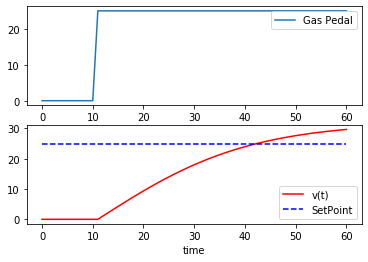

In [2]:

#Simulating Model
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
%matplotlib inline

def car(v,t,u,load):
    #Constants for Process Equation
    Cd = 0.24
    rho = 1.225
    m = 500
    A = 5
    Fp = 30
    #Process equation
    dvdt = (Fp*u - (rho*A*Cd*(v**2))/2)/(m + load)
    return dvdt

def simModel():
    #Time span
    t = np.linspace(0,60,61)
    delta_t = t[1]-t[0]

    #Initial constants
    load = 200
    v0 = 0

    #Storing Gas-Peddal/Controller Output(u) Responses
    op = np.zeros(len(t))
    #Step-Adding through Gas Peddal
    op[11:] = 25

    #Storing velocity responses
    v = np.ones(len(t))*v0

    #Simulating Model
    for i in range(len(t)-1):
        time = t[i:i+2]
        u = op[i]
        #Regenerative Breaking
        if u>=100:
            u = 100
        elif u<=-50:
            u = -50
        y = odeint(car, v0, time, args=(u, load))
        v0 = y[-1]
        v[i+1] = v0

    #Plotting
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t, op, label='Gas Pedal')
    plt.legend(loc='best')
    plt.subplot(2,1,2)
    plt.plot(t, v, 'r-', label='v(t)')
    plt.plot(t, np.ones(len(t))*25, 'b--', label='SetPoint')
    plt.xlabel('time')
    plt.legend()
    plt.show()

simModel()

##### FOPDT
By analysing the above graph we find that:
1. $K_p$ = 1.2
2. $\theta_p$ = 0
3. $\tau_p$ = 20

##### PID Tuning
Using Simple tuning rules we get:
1. $\tau_I = \tau_p = 20$
2. $K_c = 1/K_p = 1/1.2$
3. $\tau_D = 0$

In [3]:
#Simulating PID
def PID(v2, v1, SP, sum_int, delta_t, Kc, tauI, tauD, ubias):
    #Error: SP - PV
    error = SP - v2
    #Approximation of Integration of error 
    sum_int = sum_int + error*delta_t
    #Approximation of Differentiation i.e d(PV)/dt
    derivative = (v2-v1)/delta_t
    #Controller Output
    u = ubias + Kc*error + (Kc*sum_int)/tauI - (Kc*tauD*derivative)
    return u, error, sum_int, derivative

def simModelPID(Kc=1/1.2, tauI=20, tauD=0, ubias=0.0):
    #Time span
    t = np.linspace(0,300,301)
    delta_t = t[1]-t[0]
    
    #Initial constants
    load = 200
    v0 = 0
    
    #Step-Adding through set points(of velocity)
    SP = np.ones(len(t))*25
    SP[50: 100] = 0
    SP[100: 150] = 15
    SP[150: 200] = 20
    SP[200: ] = 10
    
    #Storing Velocity/Process Variable(v) responses
    v = np.ones(len(t))*v0

    #Storing Gas-Peddal/Controller Output(u) responses
    op = np.zeros(len(t))

    #Storing propotional error responses
    er = np.zeros(len(t))
    #Storing integral error responses
    ier = np.zeros(len(t))
    #Storing derivative error response
    der = np.zeros(len(t))

    #Simulating PID+Model
    sum_int = 0
    for i in range(len(t)-1):
        time=t[i:i+2]
        if i==0:
            u, error, sum_int, derivative = PID(v0, 0, SP[i], sum_int, delta_t, Kc, tauI, tauD, ubias)
        else:
            u, error, sum_int, derivative = PID(v0, v[i-1], SP[i], sum_int, delta_t, Kc, tauI, tauD, ubias)
        #Regenerative Breaking and Anti-Reset Wrapup
        if u>=100:
            u = 100
            sum_int = sum_int - error*delta_t
        elif u<=-50:
            u = -50
            sum_int = sum_int - error*delta_t
        er[i+1] = error
        ier[i+1] = sum_int
        der[i+1] = derivative
        op[i+1] = u
        y = odeint(car, v0, time, args=(u, load))
        v0 = y[-1]
        v[i+1] = v0

    #Plotting
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(5,1,1)
    plt.plot(t,v,'r-', linewidth=3, label='v(t)')
    plt.plot(t,SP,'b--', linewidth=3, label='Set Point')
    plt.legend(loc='best')
    plt.ylabel('Velocity/Process Variable')

    plt.subplot(5,1,2)
    plt.plot(t, op, 'r-', label='u(t)')
    plt.legend(loc='best')
    plt.ylabel('Gas Peddal/Controller Output')


    plt.subplot(5,1,3)
    plt.plot(t, er, 'g:')
    plt.ylabel('Proportional error')

    plt.subplot(5,1,4)
    plt.plot(t, ier, 'r:')
    plt.ylabel('Integral Error')
    
    plt.subplot(5,1,5)
    plt.plot(t, der, 'k:')
    plt.ylabel('Derivative Error')
    plt.xlabel('Time')
    plt.show()
#simModelPI()

In [4]:
interactive_plot = interactive(simModelPID, Kc=(-5.0,10.0), tauI=(0,50.0), tauD=(0, 50.0), ubias=(-1.0,5.0))
interactive_plot

interactive(children=(FloatSlider(value=0.8333333333333334, description='Kc', max=10.0, min=-5.0), FloatSlider…